In [1]:
from datasets import load_dataset, load_from_disk, Dataset, DatasetDict

from transformers import DataCollatorForLanguageModeling
from models.trainer import (
    BioSeqDataCollatorCausalLM,
)

from models.model import BioSeqMambaForCausalLM
from models.tokenizer import BioSeqBPETokenizerFast

In [2]:

tokenizer = BioSeqBPETokenizerFast.from_pretrained(
    pretrained_model_name_or_path="/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/outputs/T2T_BPE_50008_512_768_DEBUG/USE_HF_PRETRAINED",
    local_files_only=True,
)
model = BioSeqMambaForCausalLM.from_pretrained(
    pretrained_model_name_or_path="/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/outputs/T2T_BPE_50008_512_768_DEBUG/USE_HF_PRETRAINED",
    local_files_only=True,
)

/home/share/huadjyin/home/baiyong01/.local/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
model

BioSeqMambaForCausalLM(
  (model): MambaForCausalLM(
    (backbone): MambaModel(
      (embeddings): Embedding(50008, 768)
      (layers): ModuleList(
        (0-23): 24 x MambaBlock(
          (norm): MambaRMSNorm()
          (mixer): MambaMixer(
            (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
            (act): SiLU()
            (in_proj): Linear(in_features=768, out_features=3072, bias=False)
            (x_proj): Linear(in_features=1536, out_features=80, bias=False)
            (dt_proj): Linear(in_features=48, out_features=1536, bias=True)
            (out_proj): Linear(in_features=1536, out_features=768, bias=False)
          )
        )
      )
      (norm_f): MambaRMSNorm()
    )
    (lm_head): Linear(in_features=768, out_features=50008, bias=False)
  )
)

In [4]:
import torch
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(device)
model = model.to(device)

cuda:1


In [5]:
multi_raw_dataset= load_from_disk(f'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/datasets/raw_dataset_crgd_t2t_20000_200') 
multi_raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'chromosome', 'start_pos', 'end_pos'],
        num_rows: 153725
    })
    test: Dataset({
        features: ['sequence', 'chromosome', 'start_pos', 'end_pos'],
        num_rows: 2539
    })
})

In [8]:
input_seq = multi_raw_dataset['train'][0]['sequence']
len(input_seq)

20000

In [10]:
tokenized = tokenizer(input_seq,
          return_tensors="pt", max_length=10240, truncation=True)

input_ids = tokenized['input_ids'].to(device)
print(input_ids.size())


torch.Size([1, 2572])


In [11]:
input_ids

tensor([[    4,   203,  4748,  ...,   478, 11598,     8]], device='cuda:1')

In [12]:
labels = input_ids.clone().to(device)

outputs = model(input_ids=input_ids, labels=labels, return_dict=True)
outputs

MambaCausalLMOutput(loss=tensor(6.1676, device='cuda:1', grad_fn=<NllLossBackward0>), logits=tensor([[[32.6397, 33.4379, 39.4229,  ..., 31.3399, 36.6823, 25.5076],
         [46.0811, 42.4062, 43.9712,  ..., 47.2794, 47.7937, 40.5332],
         [33.8872, 30.2768, 36.4191,  ..., 34.9828, 39.8624, 27.1250],
         ...,
         [41.1761, 40.3990, 48.9294,  ..., 41.5313, 47.0667, 34.4881],
         [60.0592, 52.9218, 60.0211,  ..., 63.6801, 61.1067, 54.3297],
         [54.6356, 47.9218, 52.3918,  ..., 55.1201, 53.9941, 43.4838]]],
       device='cuda:1', grad_fn=<UnsafeViewBackward0>), cache_params=None, hidden_states=None)

In [13]:
outputs_hidden = model.model.backbone(input_ids=input_ids, labels=labels, return_dict=True)
outputs_hidden

MambaOutput(last_hidden_state=tensor([[[ 0.7593,  0.9116, -1.0575,  ..., -0.2568,  0.1005,  0.1772],
         [ 0.7442, -0.2699, -0.5742,  ..., -0.1587, -0.3843, -0.1018],
         [ 1.5385, -0.2097, -1.6574,  ..., -0.5344, -0.3233, -0.1449],
         ...,
         [-0.7280,  0.7782, -1.1227,  ..., -0.6145, -0.6484, -0.6490],
         [-1.2193,  0.2423, -0.7603,  ..., -0.2961, -0.0914, -0.6195],
         [-1.7130,  0.1614, -0.4617,  ...,  0.2033,  0.6047, -0.0116]]],
       device='cuda:1', grad_fn=<MulBackward0>), cache_params=None, hidden_states=None)

In [14]:
outputs_hidden['last_hidden_state'].size()

torch.Size([1, 2572, 768])

In [2]:
multi_raw_dataset= load_from_disk(f'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/datasets/T2T_BPE_50008_512/raw_dataset_chm13_t2t') 
multi_raw_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 882311
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 14711
    })
})

In [7]:
len(multi_raw_dataset['train'][0]['input_ids'])

512

In [5]:
multi_raw_dataset['train'][0]['input_ids'][-20:]

[78,
 369,
 90,
 858,
 2846,
 31673,
 1312,
 31497,
 4847,
 590,
 68,
 2511,
 2721,
 115,
 2117,
 33344,
 22970,
 904,
 197,
 3098]

In [8]:
multi_raw_dataset= load_from_disk(f'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/datasets/raw_dataset_multi_20000_200') 
multi_raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'start_pos', 'end_pos', 'description', 'species', 'fna_url'],
        num_rows: 8548111
    })
    test: Dataset({
        features: ['sequence', 'start_pos', 'end_pos', 'description', 'species', 'fna_url'],
        num_rows: 9891
    })
})

In [3]:
tokenized_dataset= load_from_disk(f'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/datasets/T2T_SPM_Unigram_50008_512') 

In [4]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1532267
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 25390
    })
})

In [5]:
tokenized_dataset= load_from_disk(f'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/datasets/T2T_SPM_Unigram_50008_1024') 
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 753200
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 12481
    })
})

In [2]:
# tokenized_dataset= load_from_disk(f'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/datasets/T2T_SPM_Unigram_50008_512_backup') 
# >>>
# DatasetDict({
#     train: Dataset({
#         features: ['input_ids', 'attention_mask'],
#         num_rows: 124718
#     })
#     test: Dataset({
#         features: ['input_ids', 'attention_mask'],
#         num_rows: 25390
#     })
# })

In [22]:
tokenized_dataset['train'][1]['input_ids'][:16]

[33999,
 14441,
 25092,
 29549,
 11594,
 24923,
 12508,
 4967,
 9513,
 13840,
 9696,
 30131,
 32744,
 9993,
 39512,
 3774]

In [21]:
tokenized_dataset['train'][0]['input_ids'][-17:]

[33999,
 14441,
 25092,
 29549,
 11594,
 24923,
 12508,
 4967,
 9513,
 13840,
 9696,
 30131,
 32744,
 9993,
 39512,
 3774,
 2]

# T2T

In [2]:
# T2T genome    

dataset= load_from_disk(f'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/datasets/raw_dataset_chm13_t2t_20000_200') 

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'chromosome', 'start_pos', 'end_pos'],
        num_rows: 151679
    })
    test: Dataset({
        features: ['sequence', 'chromosome', 'start_pos', 'end_pos'],
        num_rows: 2592
    })
})

In [4]:
dataset['train'][0]['sequence'][-200:]

'CGTGCACGCACATATGCACAATACAGGAAATCTGGAATACAGAAAGCCCTGGAATTCCTAAATAACATCCTGCCCACATGGGAATTCTGCCCTAGCTGATGGCTTCTCCGAGGCCTAGGCCCAAATCCACACCTGCTGTTTAGCCCAGAGCCAAGCCTAGGAGTGTAGGGTCCCCTATGCATGGGTGTCCAACCCTATCC'

In [5]:
dataset['train'][1]['sequence'][:200]

'CGTGCACGCACATATGCACAATACAGGAAATCTGGAATACAGAAAGCCCTGGAATTCCTAAATAACATCCTGCCCACATGGGAATTCTGCCCTAGCTGATGGCTTCTCCGAGGCCTAGGCCCAAATCCACACCTGCTGTTTAGCCCAGAGCCAAGCCTAGGAGTGTAGGGTCCCCTATGCATGGGTGTCCAACCCTATCC'

In [6]:
dataset['train']['sequence'][:5]

['CACCCTAAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTC

In [7]:
from models.tokenizer import BioSeqSPMTokenizer, BioSeqSPMTokenizerFast

# token path
token_path = r'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/tokens/20000_200/T2T/SPM_Unigram/50008'

tokenizer_kwargs = {
        "bos_token": "<BOS>",
        "eos_token": "<EOS>",
        "unk_token": "<UNK>",
        "add_bos_token": True,
        "add_eos_token": True,
        "add_prefix_space": False, 
        "do_lower_case": False,
        "model_max_length": 512
    }



## SentencePiece tokenizer

### Slower version

In [8]:
# 

tokenizer_class = BioSeqSPMTokenizer 
tokenier = tokenizer_class.from_pretrained(
    token_path, 
    local_files_only=True, **tokenizer_kwargs)

# add pad token
tokenier.pad_token = tokenier.eos_token

In [9]:
tokenier.pad_token_id

2

In [10]:
tokenier.added_tokens_decoder

{0: AddedToken("<BOS>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
 1: AddedToken("<UNK>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
 2: AddedToken("<EOS>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True)}

In [11]:
tokenier.convert_tokens_to_ids('<BOS>')

0

In [12]:
input_str = dataset['train']['sequence'][0][:200]
input_str

'CACCCTAAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCCTAACCCTAAC'

In [13]:
tokenizations = tokenier(input_str, 
                         add_special_tokens=False,
                         max_length=20,
                         truncation = True,
                         padding = "max_length",
                        #  stride=2,
                        #  return_overflowing_tokens = True
                         )

In [14]:
tokenizations

{'input_ids': [2586, 19, 36579, 59, 44689, 42169, 5546, 44689, 42169, 45233, 44689, 42169, 45233, 44689, 662, 45233, 18736, 2, 2, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]}

In [15]:
tokenier.decode(tokenizations['input_ids'])

'CACCCT AAA CCCTAACCCC TAA CCCTAACCCTAACCCT AACCCTAACCCTAACC CCTAAA CCCTAACCCTAACCCT AACCCTAACCCTAACC CTAACCCTAACCCTAA CCCTAACCCTAACCCT AACCCTAACCCTAACC CTAACCCTAACCCTAA CCCTAACCCTAACCCT AACCC CTAACCCTAACCCTAA CCCTAAC <EOS> <EOS> <EOS>'

In [16]:
tokenizations = tokenier(input_str, 
                         add_special_tokens=False,
                         max_length=6,
                         truncation = True,
                         padding = "max_length",
                         stride=2,
                         return_overflowing_tokens = True
                         )

In [17]:
tokenizations

{'overflowing_tokens': [44689, 42169, 5546, 44689, 42169, 45233, 44689, 42169, 45233, 44689, 662, 45233, 18736], 'num_truncated_tokens': 11, 'input_ids': [2586, 19, 36579, 59, 44689, 42169], 'attention_mask': [1, 1, 1, 1, 1, 1]}

### Fast version

In [18]:
tokenizer_class = BioSeqSPMTokenizerFast
tokenizer = tokenizer_class.from_pretrained(
    token_path, 
    local_files_only=True, padding_side='left', **tokenizer_kwargs)

# add pad token
tokenizer.pad_token = tokenizer.eos_token

In [19]:
tokenizer.pad_token_id

2

In [20]:
tokenizer.is_fast

True

In [21]:
tokenizations = tokenizer(input_str, 
                         add_special_tokens=True,
                         max_length=6,
                         truncation = True,
                         padding = "max_length",
                         stride=2,
                         return_overflowing_tokens = True,
                         return_special_tokens_mask=True,
                         )

In [22]:
tokenizations

{'input_ids': [[0, 2586, 19, 36579, 59, 2], [0, 36579, 59, 44689, 42169, 2], [0, 44689, 42169, 5546, 44689, 2], [0, 5546, 44689, 42169, 45233, 2], [0, 42169, 45233, 44689, 42169, 2], [0, 44689, 42169, 45233, 44689, 2], [0, 45233, 44689, 662, 45233, 2], [2, 0, 662, 45233, 18736, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1]], 'special_tokens_mask': [[1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 1, 0, 0, 0, 1]], 'overflow_to_sample_mapping': [0, 0, 0, 0, 0, 0, 0, 0]}

In [23]:
tokenizer.batch_decode(tokenizations['input_ids'], clean_up_tokenization_spaces=False)

# tokenizations.tokens()
# ['<BOS>', 'CACCCT', 'AAA', 'CCCTAACCCC', 'TAA', '<EOS>']

['<BOS>CACCCTAAACCCTAACCCCTAA<EOS>',
 '<BOS>CCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC<EOS>',
 '<BOS>CCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAAACCCTAACCCTAACCCT<EOS>',
 '<BOS>CCTAAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA<EOS>',
 '<BOS>AACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC<EOS>',
 '<BOS>CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCT<EOS>',
 '<BOS>CTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCCTAA<EOS>',
 '<EOS><BOS>AACCCCTAACCCTAACCCTAACCCTAAC<EOS>']

In [24]:
[tokenizations]

[{'input_ids': [[0, 2586, 19, 36579, 59, 2], [0, 36579, 59, 44689, 42169, 2], [0, 44689, 42169, 5546, 44689, 2], [0, 5546, 44689, 42169, 45233, 2], [0, 42169, 45233, 44689, 42169, 2], [0, 44689, 42169, 45233, 44689, 2], [0, 45233, 44689, 662, 45233, 2], [2, 0, 662, 45233, 18736, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1]], 'special_tokens_mask': [[1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1], [1, 1, 0, 0, 0, 1]], 'overflow_to_sample_mapping': [0, 0, 0, 0, 0, 0, 0, 0]}]

In [25]:
# from transformers import DataCollatorForLanguageModeling
# from models.trainer import (
#     BioSeqDataCollatorCausalLM,
# )

In [26]:
data_collator  = BioSeqDataCollatorCausalLM(
        tokenizer, 
        mlm=False,
        replaced_padding_id=-10
    )

In [27]:
data_collator([tokenizations])

{'input_ids': tensor([[[    0,  2586,    19, 36579,    59,     2],
         [    0, 36579,    59, 44689, 42169,     2],
         [    0, 44689, 42169,  5546, 44689,     2],
         [    0,  5546, 44689, 42169, 45233,     2],
         [    0, 42169, 45233, 44689, 42169,     2],
         [    0, 44689, 42169, 45233, 44689,     2],
         [    0, 45233, 44689,   662, 45233,     2],
         [    2,     0,   662, 45233, 18736,     2]]]), 'attention_mask': tensor([[[1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [0, 1, 1, 1, 1, 1]]]), 'overflow_to_sample_mapping': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tensor([[[    0,  2586,    19, 36579,    59,   -10],
         [    0, 36579,    59, 44689, 42169,   -10],
         [    0, 44689, 42169,  5546, 44689,   -10],
         [    0,  5546, 44689, 42169, 45233,   -10],
         [    0, 4

In [ ]:
# https://huggingface.co/learn/nlp-course/chapter7/6?fw=pt#preparing-the-dataset
# https://discuss.huggingface.co/t/how-does-gpt-decide-to-stop-generating-sentences-without-eos-token/41623

## ByteLevel Test

In [3]:
from datasets import load_dataset, load_from_disk, Dataset, DatasetDict

def gen_demo_data():
    yield {"sequence": "CACCCTAAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAAACCCT", "chr": "1"}
    yield {"sequence": "ACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTAACCCTAACCCTAACCC", "chr": "1"}
    

ds1 = Dataset.from_generator(gen_demo_data)
ds2 = Dataset.from_generator(gen_demo_data)


In [4]:
ds = DatasetDict()
ds["train"] = ds1
ds["validation"] = ds2


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['sequence', 'chr'],
        num_rows: 2
    })
    validation: Dataset({
        features: ['sequence', 'chr'],
        num_rows: 2
    })
})

In [11]:
# import os
# from models.model import BioSeqTokenizer

# vocab_size=3009 
# seq_len=1000 
# species="T2T"
# token_type="BPE"
# root_dir = r'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm'

# tokenizer_dir = os.path.join(root_dir, f'mambaDNA/tokens/{species}/{seq_len//1000}K/{token_type}/{vocab_size}')

# tokenier = BioSeqTokenizer(tokenizer_dir, 
#                            padding_side="right")

import os
from transformers import AutoTokenizer
from models.tokenizer import BioSeqBPETokenizer,BioSeqUnigramTokenizer,BioSeqBPETokenizerFast, BioSeqUnigramTokenizerFast

vocab_size=3010 
seq_len=1000 
species="T2T"
token_type="Unigram"
root_dir = r'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm'

tokenizer_dir = os.path.join(root_dir, f'mambaDNA_bak20240404/tokens/{species}/{seq_len//1000}K/{token_type}/{vocab_size}')

tokenizer_kwargs = {
        "bos_token": "<BOS>",
        "eos_token": "<EOS>",
        "pad_token": "<PAD>",
        "unk_token": "<UNK>",
        "mask_token": "<MASK>",
        "padding_side": "right",
        "add_bos_token": True,
        "add_eos_token": True,
        "add_prefix_space": False, 
        "do_lower_case": False,
        "model_max_length": 512
    }

# tokenier = AutoTokenizer.from_pretrained(tokenizer_dir, use_fast=True, trust_remote_code=True, **tokenizer_kwargs)
tokenizer_class = BioSeqUnigramTokenizer 
tokenier = tokenizer_class.from_pretrained(
    tokenizer_dir, 
    local_files_only=True, **tokenizer_kwargs)


In [2]:
tokenier.model_max_length

512

In [10]:
# tokenier.add_tokens(['ADDED'])
# tokenier.convert_tokens_to_ids(["ADDED"])
# tokenier.added_tokens_decoder

{0: AddedToken("<BOS>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 1: AddedToken("<UNK>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 2: AddedToken("<EOS>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 3: AddedToken("<MASK>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 4: AddedToken("<PAD>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 3010: AddedToken("ADDED", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False)}

In [5]:
ds['train']['sequence']

['CACCCTAAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAAACCCT',
 'ACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTCACCCTAACCCTAACCCTAACCC']

In [6]:
# https://github.com/huggingface/transformers/issues/23001
tokenizations = tokenier(ds['train']['sequence'][0], 
                        #  add_special_tokens=True,
                         max_length=6,
                         truncation = True,
                         padding = "max_length",
                         stride=2,
                         return_overflowing_tokens = True
                         )

# encoded_inputs["num_truncated_tokens"] = total_len - max_length

In [7]:
tokenizations

{'input_ids': [[0, 838, 69, 698, 521, 2], [0, 698, 521, 329, 864, 2], [0, 329, 864, 698, 521, 2], [0, 698, 521, 69, 864, 2], [0, 69, 864, 698, 521, 2], [0, 698, 521, 806, 196, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]], 'overflow_to_sample_mapping': [0, 0, 0, 0, 0, 0]}

In [61]:
tokenizations

{'overflowing_tokens': [698, 521, 329, 864, 698, 521, 69, 864, 698, 521, 806, 196], 'num_truncated_tokens': 10, 'input_ids': [0, 838, 69, 698, 521, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [48]:
tokenier(ds['train']['sequence'][0])['input_ids']

[0, 838, 69, 698, 521, 329, 864, 698, 521, 69, 864, 698, 521, 806, 196, 2]

In [37]:
tokenier.decode(tokenier(ds['train']['sequence'][1])['input_ids'])

'<BOS> ACC CTCACC CTCACC CTCACC CTCACC CTCACC CTCACC CTCACC CTAA CCCTA ACCCT AACCC <EOS>'

In [8]:
tokenier.save_pretrained(tokenizer_dir)

('/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/mambaDNA_bak20240404/tokens/T2T/1K/Unigram/3010/tokenizer_config.json',
 '/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/mambaDNA_bak20240404/tokens/T2T/1K/Unigram/3010/special_tokens_map.json',
 '/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/mambaDNA_bak20240404/tokens/T2T/1K/Unigram/3010/tokenizer.json')

In [7]:
tokenized_ds = tokenier(ds, 
                        max_length=6, 
                        truncation=True,
                        padding=True,
                        return_overflowing_tokens=True, 
                        stride=2, 
                        min_tokens_exclude_stride=0.0,
                        remove_columns=ds["train"].column_names, add_special_tokens=True)

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [8]:
tokenized_ds['train']

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 12
})

In [9]:
tokenized_ds['train'][:]

{'input_ids': [[0, 5, 62, 21, 62, 0],
  [0, 21, 62, 21, 253, 0],
  [0, 21, 253, 1225, 1225, 0],
  [0, 1225, 1225, 1225, 1225, 0],
  [0, 1225, 1225, 1225, 21, 0],
  [0, 1225, 21, 253, 21, 0],
  [0, 253, 21, 62, 8, 0],
  [0, 62, 517, 517, 517, 0],
  [0, 517, 517, 517, 517, 0],
  [0, 517, 517, 517, 517, 0],
  [0, 517, 517, 1225, 1225, 0],
  [0, 1225, 1225, 1225, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 0]]}

In [12]:
tokenier.tokenizer.decode(tokenized_ds["train"]["input_ids"][0])

'<BOS> C ACCC TAA ACCC <EOS>'

In [8]:
from models.model import BioSeqDataCollator
data_collator  = BioSeqDataCollator(tokenier.tokenizer, mlm=False, replaced_padding_id=tokenier.tokenizer.pad_token_id)

In [21]:
[tokenized_ds["train"][i] for i in range(5)]

[{'input_ids': [0, 5, 62, 21, 62, 2],
  'token_type_ids': [0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1]},
 {'input_ids': [0, 21, 62, 21, 253, 2],
  'token_type_ids': [0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1]},
 {'input_ids': [0, 21, 253, 1225, 1225, 2],
  'token_type_ids': [0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1]},
 {'input_ids': [0, 1225, 1225, 1225, 1225, 2],
  'token_type_ids': [0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1]},
 {'input_ids': [0, 1225, 1225, 1225, 21, 2],
  'token_type_ids': [0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1]}]

In [19]:
out = data_collator([tokenized_ds["train"][i] for i in range(5)])

In [20]:
out

{'input_ids': tensor([[   0,    5,   62,   21,   62,    2],
        [   0,   21,   62,   21,  253,    2],
        [   0,   21,  253, 1225, 1225,    2],
        [   0, 1225, 1225, 1225, 1225,    2],
        [   0, 1225, 1225, 1225,   21,    2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]]), 'labels': tensor([[   0,    5,   62,   21,   62,    2],
        [   0,   21,   62,   21,  253,    2],
        [   0,   21,  253, 1225, 1225,    2],
        [   0, 1225, 1225, 1225, 1225,    2],
        [   0, 1225, 1225, 1225,   21,    2]])}

In [22]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(tokenized_ds["train"], batch_size=5, shuffle=False,collate_fn=data_collator)


In [23]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[   0,    5,   62,   21,   62,    2],
        [   0,   21,   62,   21,  253,    2],
        [   0,   21,  253, 1225, 1225,    2],
        [   0, 1225, 1225, 1225, 1225,    2],
        [   0, 1225, 1225, 1225,   21,    2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]]), 'labels': tensor([[   0,    5,   62,   21,   62,    2],
        [   0,   21,   62,   21,  253,    2],
        [   0,   21,  253, 1225, 1225,    2],
        [   0, 1225, 1225, 1225, 1225,    2],
        [   0, 1225, 1225, 1225,   21,    2]])}


In [1]:
import torch

x = torch.tensor(
    [[0, 3, 5, 6, 6],
     [2, 4, 5, 7, 9]]
).to("cuda")


In [6]:
x

tensor([[0, 3, 5, 6, 6],
        [2, 4, 5, 7, 9]], device='cuda:0')

In [2]:
from models.model import BioSeqMambaConfig, BioSeqForCausalLM
from models.utils import model_size

_config = BioSeqMambaConfig()#(d_model=5, n_layer=3, vocab_size=30)
lm_model = BioSeqForCausalLM(config=_config, device="cuda", dtype=torch.float32)

In [4]:
print(f"model size: {model_size(lm_model)/1000**2:.1f}M parameters")

model size: 371.5M parameters


In [9]:
y = lm_model(x)

In [11]:
y.logits.shape

torch.Size([2, 5, 32])

In [12]:
z = lm_model.backbone(x)

In [13]:
z.shape

torch.Size([2, 5, 5])

In [41]:
out

{'input_ids': tensor([[[   0,    5,   62,   21,   62,    2],
          [   0,   21,   62,   21,  253,    2],
          [   0,   21,  253, 1225, 1225,    2],
          [   0, 1225, 1225, 1225, 1225,    2],
          [   0, 1225, 1225, 1225,   21,    2],
          [   0, 1225,   21,  253,   21,    2],
          [   0,  253,   21,   62,    8,    2],
          [   0,   62,  517,  517,  517,    2],
          [   0,  517,  517,  517,  517,    2],
          [   0,  517,  517,  517,  517,    2],
          [   0,  517,  517, 1225, 1225,    2]],
 
         [[   1,    1,    1,    1,    1,    1],
          [   1,    1,    1,    1,    1,    1],
          [   1,    1,    1,    1,    1,    1],
          [   1,    1,    1,    1,    1,    1],
          [   1,    1,    1,    1,    1,    1],
          [   1,    1,    1,    1,    1,    1],
          [   1,    1,    1,    1,    1,    1],
          [   1,    1,    1,    1,    1,    1],
          [   1,    1,    1,    1,    1,    1],
          [   1,    1,  

In [27]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2
    })
})

In [26]:
tokenized_ds["train"]["input_ids"]

[[[0,
   5,
   62,
   21,
   62,
   21,
   253,
   1225,
   1225,
   1225,
   1225,
   1225,
   21,
   253,
   21,
   62,
   8,
   2]],
 [[0, 62, 517, 517, 517, 517, 517, 517, 517, 1225, 1225, 1225, 2]]]

In [12]:
tokenized_ds["train"]["token_type_ids"]

[[[0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0]]]

In [13]:
tokenized_ds["train"]["attention_mask"]

[[[1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1]],
 [[1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 0]]]

In [14]:
tokenized_ds["train"]["overflow_to_sample_mapping"]

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]

In [8]:
tokenier.tokenizer.decode(tokenized_ds["train"]["input_ids"][0])

'<BOS> C ACCC TAA ACCC <EOS>'

In [9]:
tokenier.tokenizer.decode(tokenized_ds["train"]["input_ids"][1])

'<BOS> ACCC TCACCC TCACCC TCACCC <EOS>'

In [4]:
dt = dataset["train"].shuffle(seed=42).select(range(100000))


Dataset({
    features: ['sequence', 'chromosome', 'start_pos', 'end_pos'],
    num_rows: 100000
})

In [6]:
dt[0]

{'sequence': 'ATGTGCCTTTATGGTAGAAAAATTTTCCTCTGGATATACACCTAGTAATGGCATTGCTGGGTTGAATGCTAGTTCTCCTTTTAACTCTTTAAGAAATTGCTACACTGCTTTGGTTGCACTTATTTGCACTCCCGCCAACAGCATGTAAGGGTTCCCTTTTCTCTGCAACCTCGCTAACATCTATTATTTTTTGACTTTTTAATAATAGTCATTCTGACTGTGGTTTTGATTTGCATTTCTCCAATGATCAGTGATATTGAGTTTTTTTTCACATGATTATTGGCCACATGTATGTCTTCTTTAAAAGTATCTGTTCAGGTTCTTTGCCCACTTTTTATTGGGGTTGTTTTTTTCTTGTAAATTTGTTTAAGTTTCTTATAGATGCGAATATTAGACCTTTGTCAGATGCATCGTTCAGTGATGGAAAAGCAGCTACTATGCAGTCAGAGATAGATGGAGGTTAAAAAAAATAAAGCAAGCTTCCTATAATCTGTAGCTCATAATGTTCTGGGAGAAATAGCTGCATGCCAAAGTAGCATTTTAAAAAAAAGACAAAGAAGAGTACAATTATTTAAATTATAACCCCTATATGTTAAATTTCAAAGTACATTTTCGCTAACCTCTAGGGTCAGTACATGCATAATCTTCTCTTAGTATTTTATGATATAAGTCCATGGTATTGACTGACATTAATCAAAAGGAAAAATTAGTTTATTCTGTTTTTGTATAGAACAGATATTTTTAATATGTTATTTCTCCCCAGAATAAACATAGAATCCTGTTAGAATATGTCTTGGAAATTATTATTATTGAAATTTCAGGTATGAACTTTTAGAGACAGGGCGATTTTCTTGGAGACAGAAGAGACATTGGATCTAGGCAGATCTGAATTCCCAGACTTGTGGCGGTTATTTTAACCCCTCTGGAACTCTGTTGCCTCTTCTTTGTACCTGTGAACTGTTGGTAATAAATCCTACAGTATGTTG

In [1]:
import os

from transformers import PreTrainedTokenizerFast


vocab_size=3009 
seq_len=1000 
species="T2T"
token_type="BPE"
root_dir = r'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm'

tokenizer_dir = os.path.join(root_dir, f'mambaDNA/tokens/{species}/{seq_len//1000}K/{token_type}/{vocab_size}')

In [1]:
import os

from transformers import PreTrainedTokenizerFast


vocab_size=3009 
seq_len=1000 
species="T2T"
token_type="BPE"
root_dir = r'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm'

tokenizer_dir = os.path.join(root_dir, f'mambaDNA/tokens/{species}/{seq_len//1000}K/{token_type}/{vocab_size}')

tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_dir, local_files_only=True)


# print(tokenizer.encode("ATTTCTCTCTCTCTCTGAGATCGATCGATCGAT").tokens)
# ['ATT', 'TCTCTCTCTCTC', 'TGAGATCG', 'ATCG', 'ATCG', 'AT']

# with open(os.path.join(token_dir, 'unigram.json')) as f:
#     vocab = json.load(f)['vocab']
#     # for idx, v in enumerate(vocab):
#     #     vocab[idx] = tuple(v)

# tokenizer_unigram = BioSeqUnigramTokenizer(
#     vocab
# )
# # tokenizer_unigram.
# tokenizer_unigram.save_model(root_dir)

# print(tokenizer_unigram.encode("ATTTCTCTCTCTCTCTGAGATCGATCGATCGAT").tokens)
# ['ATT', 'TCTCTCTCTCTC', 'TGAGATC', 'GATC', 'GATCGAT']


In [4]:
tokenizer.encode("ATTTCTCTCTCTC<EOS>TCTGAGATCGATCGATCGAT")

[0, 17, 605, 14, 2, 63, 218, 6, 276, 276, 18, 2]

In [4]:
# tokenizer_unigram.save_model(root_dir)

['/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/unigram.json']

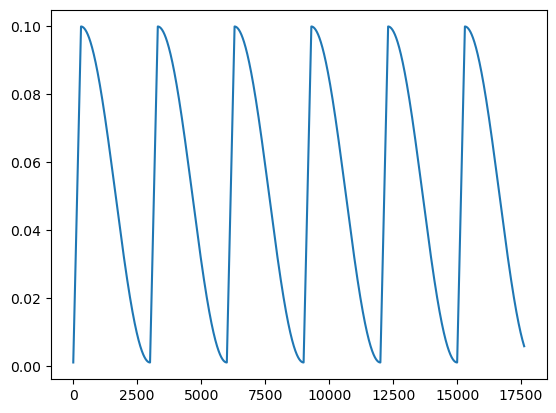

In [3]:

import os
import torch.nn as nn
from torch import optim

from models.model import CosineAnnealingWarmupRestarts

import matplotlib.pyplot as plt

epochs = 10
steps_per_epoch = 1762
warmup_period = 2000
num_steps = steps_per_epoch * epochs - warmup_period

t0 = num_steps // 3
lr_min = 3e-5
max_step = t0 * 3 + warmup_period

model = nn.Linear(100, 10)

optimizer = optim.AdamW(model.parameters(),
                        lr=0.01,
                        betas=(0.9, 0.999),
                        weight_decay=0.01)

lr_scheduler = CosineAnnealingWarmupRestarts(
  optimizer, first_cycle_steps=3000, 
  cycle_mult=1.0, max_lr=0.1, 
  min_lr=0.001, warmup_steps=300, gamma=1.0)

learning_rates = []
for epoch in range(1, epochs + 1):
  for iter in range(steps_per_epoch):
    lr = optimizer.param_groups[0]['lr']
    learning_rates.append(lr)
    optimizer.step()
    lr_scheduler.step()

iterations = list(range(1, len(learning_rates)+1))
plt.plot(iterations, learning_rates)



In [46]:
vocab_json

OrderedDict([('type', 'Unigram'),
             ('unk_id', 1),
             ('vocab',
              [['<BOS>', 0.0],
               ['<UNK>', 0.0],
               ['<EOS>', 0.0],
               ['A', -4.519336914248859],
               ['T', -4.522675687833219],
               ['C', -4.640659545654051],
               ['G', -4.650411864936025],
               ['TT', -5.0573638668177825],
               ['AA', -5.109823203981929],
               ['CA', -5.1142508467559935],
               ['CT', -5.118946914821089],
               ['AG', -5.119881313508914],
               ['TG', -5.132989023407864],
               ['AT', -5.142030087799107],
               ['GT', -5.166273662026013],
               ['AC', -5.25625883968001],
               ['GG', -5.342975624732167],
               ['TC', -5.36763560348653],
               ['GC', -5.371473416185147],
               ['CC', -5.37880905389018],
               ['GA', -5.389236397480257],
               ['TTT', -5.528269173753145],
         

# Multi-species genome

In [3]:
import os
import pandas as pd
import numpy as np

In [1]:
# multi-species genome
data_file = {"multi_species_urls": r"/home/share/huadjyin/home/baiyong01/projects/biomlm/data/multi_species_genomes/update_urls.csv"}
data_dir = r"/home/share/huadjyin/home/baiyong01/projects/biomlm/data/multi_species_genomes/original_urls_data"
# dataset = load_dataset('/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/datasets/dataset_multi.py', 
#                        trust_remote_code=True, 
#                        chunk_len=20000, 
#                        overlap=200,
#                        data_files = data_file,
#                        data_dir=data_dir,
#                        # cache_dir='/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/datasets'
#                        )

In [9]:


# rewrite the url
# update_urls = open(r'/home/share/huadjyin/home/baiyong01/projects/biomlm/data/multi_species_genomes/update_urls.csv', 'w')
update_urls = {'original_url': [], 'species': [], 'updated_url': []}
with open(data_file['multi_species_urls'], 'rt', encoding='utf-8') as f:
    for line in f:
        url = line.rstrip()
        url_split = url.split('/')

        species = url_split[5]

        seq_annot = url_split[-2]
        fname = url.split('/')[-1]

        # special case
        if seq_annot == 'GCF_003031525.2_Neophocaena_asiaeorientalis_V1':
            seq_annot = 'GCF_003031525.2_Neophocaena_asiaeorientalis_V1.1'
            fname = 'GCF_003031525.2_Neophocaena_asiaeorientalis_V1.1_genomic.fna.gz'

        assembly_accesion1 = fname[4:7]
        assembly_accesion2 = fname[7:10]
        assembly_accesion3 = fname[10:13]

        update_url = f'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/{assembly_accesion1}/{assembly_accesion2}/{assembly_accesion3}/{seq_annot}/{fname}'

        update_urls["original_url"].append(url)
        update_urls["species"].append(species)
        update_urls["updated_url"].append(update_url)

pd.DataFrame(data=update_urls).to_csv(r'/home/share/huadjyin/home/baiyong01/projects/biomlm/data/multi_species_genomes/update_urls.csv', index=False)


In [4]:
update_urls_pd = pd.read_csv(r'/home/share/huadjyin/home/baiyong01/projects/biomlm/data/multi_species_genomes/update_urls.csv')

with open(data_file['multi_species_urls'], 'rt', encoding='utf-8') as f:
    urls = []
    for line in f:
        url = line.rstrip()

        downloaded_f_name = os.path.join(data_dir, url.split('/')[-1])
        if not os.path.exists(downloaded_f_name):
            urls.append(url)

update_urls_pd.loc[update_urls_pd['original_url'].isin(urls), 'updated_url'].to_csv(r'/home/share/huadjyin/home/baiyong01/projects/biomlm/data/multi_species_genomes/undownload_url.csv', header=None, index=False)

In [27]:
update_urls_pd = pd.read_csv(r'/home/share/huadjyin/home/baiyong01/projects/biomlm/data/multi_species_genomes/update_urls.csv')


In [31]:
update_urls_pd["updated_url"].tolist()

['https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/566/705/GCF_000566705.1_Ba3549/GCF_000566705.1_Ba3549_genomic.fna.gz',
 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/020/145/GCF_000020145.1_ASM2014v1/GCF_000020145.1_ASM2014v1_genomic.fna.gz',
 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/429/985/GCF_000429985.1_ASM42998v1/GCF_000429985.1_ASM42998v1_genomic.fna.gz',
 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/003/610/495/GCF_003610495.1_ASM361049v1/GCF_003610495.1_ASM361049v1_genomic.fna.gz',
 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/003/687/485/GCF_003687485.1_ASM368748v1/GCF_003687485.1_ASM368748v1_genomic.fna.gz',
 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/008/124/615/GCF_008124615.1_ASM812461v1/GCF_008124615.1_ASM812461v1_genomic.fna.gz',
 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/012/720/095/GCF_012720095.1_ASM1272009v1/GCF_012720095.1_ASM1272009v1_genomic.fna.gz',
 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/002/012/345/GCF_002012345.1_ASM201234v1/GCF

# TOKEN Distribution

In [3]:
from models.tokenizer import BioSeqSPMTokenizer, BioSeqSPMTokenizerFast

# token path
token_path = r'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/tokens/20000_200/T2T/SPM_Unigram/50008'

tokenizer_kwargs = {
        "bos_token": "<BOS>",
        "eos_token": "<EOS>",
        "unk_token": "<UNK>",
        "add_bos_token": True,
        "add_eos_token": True,
        "add_prefix_space": False, 
        "do_lower_case": False,
        "model_max_length": 512
    }

tokenizer = BioSeqSPMTokenizer.from_pretrained(
    token_path, 
    local_files_only=True, **tokenizer_kwargs)

# add pad token
tokenizer.pad_token = tokenizer.eos_token

In [6]:
tokens_dict = tokenizer.get_vocab()
token_ls_ = list(tokens_dict.keys())

In [10]:
token_ls_[3:]

['TG',
 'CA',
 'AC',
 'GT',
 'AG',
 'CT',
 'AT',
 'GA',
 'TA',
 'CG',
 'GG',
 'TC',
 'AA',
 'CC',
 'GC',
 'TT',
 'AAA',
 'TTT',
 'CTG',
 'CTT',
 'CAG',
 'ATG',
 'AAT',
 'AAG',
 'ACA',
 'CAA',
 'TCA',
 'CAT',
 'AGT',
 'TGT',
 'TTG',
 'TCT',
 'CCT',
 'AGA',
 'TGA',
 'AGG',
 'CCA',
 'TGG',
 'ATT',
 'ACT',
 'GAG',
 'CAC',
 'GTG',
 'TGC',
 'GAA',
 'TCC',
 'CTC',
 'GCA',
 'TTC',
 'GGA',
 'TTTT',
 'TAG',
 'CCC',
 'ATA',
 'TAT',
 'GGG',
 'TAA',
 'CTA',
 'TTA',
 'AAC',
 'GAT',
 'GTT',
 'GCT',
 'AGC',
 'GTA',
 'TCTT',
 'AAAA',
 'ACC',
 'TAC',
 'GGT',
 'ATC',
 'TTCT',
 'GCC',
 'GAC',
 'ATTT',
 'GGC',
 'CAAA',
 'AATG',
 'CGT',
 'GAAT',
 'TGAG',
 'CTTG',
 'AAAT',
 'AGAA',
 'CAAG',
 'TGCT',
 'TCAT',
 'CATT',
 'GTC',
 'AGCA',
 'TTTG',
 'ACG',
 'AAGA',
 'CATG',
 'CTTT',
 'CCTG',
 'CAGG',
 'CACT',
 'AGTG',
 'AAAG',
 'CAGA',
 'CCG',
 'TCTG',
 'ACTG',
 'TGTG',
 'CACA',
 'ACAG',
 'TGGA',
 'CTGT',
 'GTTT',
 'TGTT',
 'ATGG',
 'AAAC',
 'TACA',
 'ATTG',
 'AGGA',
 'CAAT',
 'CTCT',
 'CAGT',
 'TCCT',
 'AGAG',
 '

input arguments, seq_len: 1000, specises: T2T, token_type: SPM_Unigram
token_len_mean: 8.957704229577041


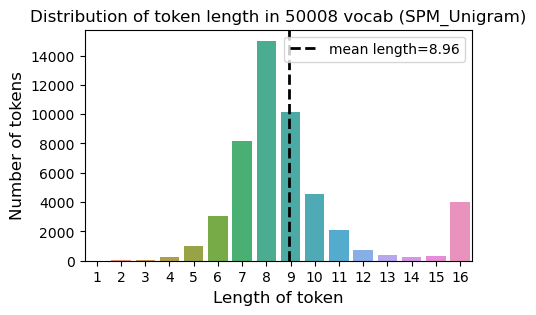

In [12]:
import os
import json
from collections import OrderedDict, Counter

import matplotlib.pyplot as plt
import seaborn as sns

seq_len = 1000  # the seq length when generate tokens
species = 'T2T'
token_type = 'SPM_Unigram'
print(f"input arguments, seq_len: {seq_len}, specises: {species}, token_type: {token_type}")
root_dir = r'/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm'

vocab_sizes =  [50008]

vocab_size = vocab_sizes[0]
token_dir = os.path.join(root_dir, f'mambaDNA/tokens/{species}/{seq_len//1000}K/{token_type}/{vocab_size}')
if token_type == "BPE":
    vocab_file = os.path.join(token_dir, 'vocab.json')
    with open(vocab_file, 
                mode='rt', 
                encoding="utf-8"
        ) as vocab_f:    
        vocab_json = json.load(vocab_f, object_pairs_hook=OrderedDict)
        token_ls_ = list(vocab_json.keys())
if token_type == "Unigram":
    vocab_file = os.path.join(token_dir, 'unigram.json')
    with open(vocab_file, 
                mode='rt', 
                encoding="utf-8"
        ) as vocab_f:    
        vocab_json = json.load(vocab_f, object_pairs_hook=OrderedDict)
        token_ls_ = [tokens[0] for tokens in vocab_json['vocab']]
    
token_ls = token_ls_[3:] # exclude special tokens
token_len = Counter(map(len, token_ls))
token_len_mean = sum([k*v  for k, v in token_len.items()])/sum([v  for k, v in token_len.items()])
print(f'token_len_mean: {token_len_mean}')

fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(x = list(token_len.keys()),y = list(token_len.values()), ax=ax)
plt.axvline(token_len_mean-1, color='k', ls='--', lw=2, label=f'mean length={token_len_mean:.2f}') 
plt.title(f'Distribution of token length in {vocab_size} vocab ({token_type})')
plt.ylabel('Number of tokens', fontsize=12)
plt.xlabel('Length of token', fontsize=12)
plt.legend()
plt.show()


# DNA Generation

In [1]:
from typing import Optional
import torch
import torch.nn.functional as F

def seq_generate(
        model,
        tokenizer,
        prompt: str,
        n_tokens_to_gen: int = 50,
        sample: bool = True,
        top_k: Optional[int] = 40
):
    model.eval()
    input_ids = tokenizer(prompt).input_ids

    for token_n in range(n_tokens_to_gen):
        with torch.no_grad():
            idx_to_input = input_ids
            next_token_logits = model(idx_to_input)["logits"][:, -1]

        probs = F.softmax(next_token_logits, dim=-1)
        (batch, vocab_size) = probs.shape

        if top_k is not None:
            (values, indices) = torch.topk(probs, k=top_k)
            probs[probs < values[:, -1, None]] = 0
            probs = probs / probs.sum(axis=1, keepdims=True)
        if sample:
            next_indices = torch.multinomial(probs, num_samples=1)
        else:
            next_indices = torch.argmax(probs, dim=-1)[:, None]
        input_ids = torch.cat([input_ids, next_indices], dim=1)
    
    output_completions = [tokenizer.decode(output.tolist()) for output in input_ids][0]

    return output_completions
    

In [22]:
from models.model import (
    BioSeqForCausalLM,
)
model_path = r"/home/share/huadjyin/home/baiyong01/projects/biomlm/biomlm/outputs"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# pretrained_model = BioSeqForCausalLM.from_pretrained(model_path, device=device, dtype=torch.float32)

In [23]:
from transformers import PreTrainedTokenizerFast
pretrained_tokenizer = PreTrainedTokenizerFast.from_pretrained(model_path, local_files_only=True)

In [24]:
pretrained_tokenizer.vocab_size

3009

In [25]:
prompt = "ATGTGCCTTTATGGTAGAAAAATTTT"
input_ids = pretrained_tokenizer.encode(prompt, return_tensors='pt')[:,1:-1]

In [26]:
# input_ids = input_ids.to(device)

In [33]:
input_ids

tensor([[1071, 1871,  731,  100,    0,   13,   13,   13,   31,  308,   31,  299,
         1512,   31,   78,   13,   21,  156, 2770, 1558, 2748,   21,  250,    0,
            0, 1561,   13,  253,   13,   37,  253,   13,  253,   13, 3008,  522,
         2932,  396,   31, 1789,  265,   31, 2897, 2897, 2897, 2897, 2328,    0,
            0,    0,   56,    0,    0,   56]], device='cuda:0')

In [47]:
n_tokens_to_gen: int = 5
sample: bool = False
top_k: Optional[int] = 10

In [48]:
pretrained_model.eval()

BioSeqForCausalLM(
  (backbone): BioSeqMixerModel(
    (embedding): Embedding(3016, 1024)
    (layers): ModuleList(
      (0-47): 48 x Block(
        (mixer): Mamba(
          (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
          (act): SiLU()
          (x_proj): Linear(in_features=2048, out_features=96, bias=False)
          (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
        (norm): RMSNorm()
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=1024, out_features=3016, bias=False)
)

In [49]:
for token_n in range(n_tokens_to_gen):
    with torch.no_grad():
        idx_to_input = input_ids
        next_token_logits = pretrained_model(idx_to_input)["logits"][:, -1]

    probs = F.softmax(next_token_logits, dim=-1)
    (batch, vocab_size) = probs.shape

    if top_k is not None:
        (values, indices) = torch.topk(probs, k=top_k)
        probs[probs < values[:, -1, None]] = 0
        probs = probs / probs.sum(axis=1, keepdims=True)
    if sample:
        next_indices = torch.multinomial(probs, num_samples=1)
    else:
        next_indices = torch.argmax(probs, dim=-1)[:, None]
    input_ids = torch.cat([input_ids, next_indices], dim=1)

In [50]:
output_completions = [pretrained_tokenizer.decode(output.tolist()) for output in input_ids][0]

In [51]:
output_completions

'ATGTGCC TTTATGG TAGAAAA ATTTT <BOS> CC CC CC TTTT TAATAA TTTT TAATTTT TGATAG TTTT TTGC CC TAA TATTG TATTTTTG TTAATTTT TGATAAAA TAA TTTAT <BOS> <BOS> TCCCACC CC CCCC CC CCC CCCC CC CCCC CC CCCACC CCCAGC TTGCTTTC TTTTGG TTTT AGCTTTT TGATT TTTT TTATTTTTT TTATTTTTT TTATTTTTT TTATTTTTT TGAGATGG <BOS> <BOS> <BOS> TTTG <BOS> <BOS> TTTG TTCTTTT TTTCTTTTC TTTT TTATTTTTT TGAGAC <BOS> C TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCCTTTC TTCC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC TTTCTCTC'

: 

: 

: 

: 

In [46]:
# ATGTGCCTTTATGGTAGAAAAATTTT CCTCTGGATATACACCTAGTAATGGCATTGCTGGGTTGAATGCTAGTTCTCCTTTTAACTCTTTAAGAAATTGCTACACTGCTT

SyntaxError: invalid syntax (1638576890.py, line 1)